## CSC555 - Final Project

### Name: Lakshmi Sowjanya Gangumolu

### Title: Predicting review score on Amazon product Data

## Dataset Overview

### Introduction
The dataset utilized for this project is a collection of consumer reviews from Amazon. It encompasses various products reviewed by customers, capturing their feedback and ratings. The dataset was sourced from kaggle. The primary objective of this project is to predict the rating score (1 to 5) given by users to different products based on the review text and other features.

#### Dataset Specifications

- Total Records: 568,454
- Total Columns: 10
- File size: 300 MB

#### Attributes

- Id: Unique identifier for each review.
- ProductId: Identifier for the reviewed product.
- UserId: Identifier for the user who wrote the review.
- ProfileName: Name of the user profile.
- HelpfulnessNumerator: Number of users who found the review helpful.
- HelpfulnessDenominator: Number of users who indicated whether the review was helpful.
- Score: Rating given by the user (1 to 5).
- Time: Timestamp for when the review was posted.
- Summary: Brief summary or title of the review.
- Text: Full text of the review.

**Source** : https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews/data

In [5]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan
import seaborn as sns
import pandas as pd
import boto3
import matplotlib.pyplot as plt
import re

# Initialize Spark session
spark = SparkSession.builder \
    .appName("AmazonReviews") \
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
#Read data from S3 
df = spark.read.csv("s3://lgangumo2/Reviews.csv", header=True, inferSchema=True)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Exploratory Data Analysis

In [8]:
#Schema of the dataset 
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- Id: integer (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: string (nullable = true)
 |-- HelpfulnessDenominator: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)

In [9]:
df.show(6)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
| Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|
+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
|  1|B001E4KFG0|A3SGXH7AUHU8GW|          delmartian|                   1|                     1|    5|1303862400|Good Quality Dog ...|I have bought sev...|
|  2|B00813GRG4|A1D87F6ZCVE5NK|              dll pa|                   0|                     0|    1|1346976000|   Not as Advertised|"Product arrived ...|
|  3|B000LQOCH0| ABXLMWJIXXAIN|"Natalia Corres "...|                   1|                     1|    4|1219017600|"""Delight"" says...|"This is a confec...|
|  4|B000UA0QIQ|A395BORC6FGVXV|                Karl|            

In [10]:
# Count the number of records
record_count = df.count()
print(f"Total number of records: {record_count}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total number of records: 568454

In [14]:
# Summary statistics for numerical columns
df.describe(["HelpfulnessNumerator", "HelpfulnessDenominator", "Score"]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+----------------------+-----------------+
|summary|HelpfulnessNumerator|HelpfulnessDenominator|            Score|
+-------+--------------------+----------------------+-----------------+
|  count|              568452|                568452|           568451|
|   mean|  1.7404362359754146|    2.2252822569278043|4.176305349530591|
| stddev|   7.641562467566166|     8.287606784659728|1.383877970723668|
|    min|            Judie"""|            & Books"""|             ..."|
|    max|                wife|               fur-mom|  book-blogger"""|
+-------+--------------------+----------------------+-----------------+

It seems there are issues with the dataset where non-numeric values are present in the HelpfulnessNumerator, HelpfulnessDenominator, and Score columns, which should contain numeric values.

### Data preprocessing

In [15]:
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType, DoubleType, IntegerType
# Function to filter out non-numeric values
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

# Register the UDF
is_number_udf = udf(is_number, BooleanType())

# Filter out rows with non-numeric values in numeric columns
df_filtered = df.filter(
    is_number_udf(col("HelpfulnessNumerator")) &
    is_number_udf(col("HelpfulnessDenominator")) &
    is_number_udf(col("Score"))
)


# Convert columns to appropriate data types
df_filtered = df_filtered.withColumn("HelpfulnessNumerator", col("HelpfulnessNumerator").cast(IntegerType()))
df_filtered = df_filtered.withColumn("HelpfulnessDenominator", col("HelpfulnessDenominator").cast(IntegerType()))
df_filtered = df_filtered.withColumn("Score", col("Score").cast(DoubleType()))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
# Drop rows with missing values
df_clean = df_filtered.dropna()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let us review the summmary statistics after cleaning the data

In [18]:
# Summary statistics for numerical columns after cleaning
df_clean.describe(["HelpfulnessNumerator", "HelpfulnessDenominator", "Score"]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+----------------------+-----------------+
|summary|HelpfulnessNumerator|HelpfulnessDenominator|            Score|
+-------+--------------------+----------------------+-----------------+
|  count|              565703|                565703|           565703|
|   mean|  1.7404362359754146|     2.225236564062768|4.183195068790514|
| stddev|   7.641562467566166|       8.2938265948621|1.311116531273438|
|    min|                   0|                     0|              1.0|
|    max|                 866|                   923|              5.0|
+-------+--------------------+----------------------+-----------------+

In [23]:
# Count the number of records after cleaning
record_count = df_clean.count()
print(f"Total number of records after cleaning: {record_count}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total number of records after cleaning: 565703

In [24]:
# Extract the Score column
scores = df_clean.select("Score").collect()

# Convert to a flat list
scores = [row.Score for row in scores]

scores_df = pd.DataFrame(scores, columns=["Score"])



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

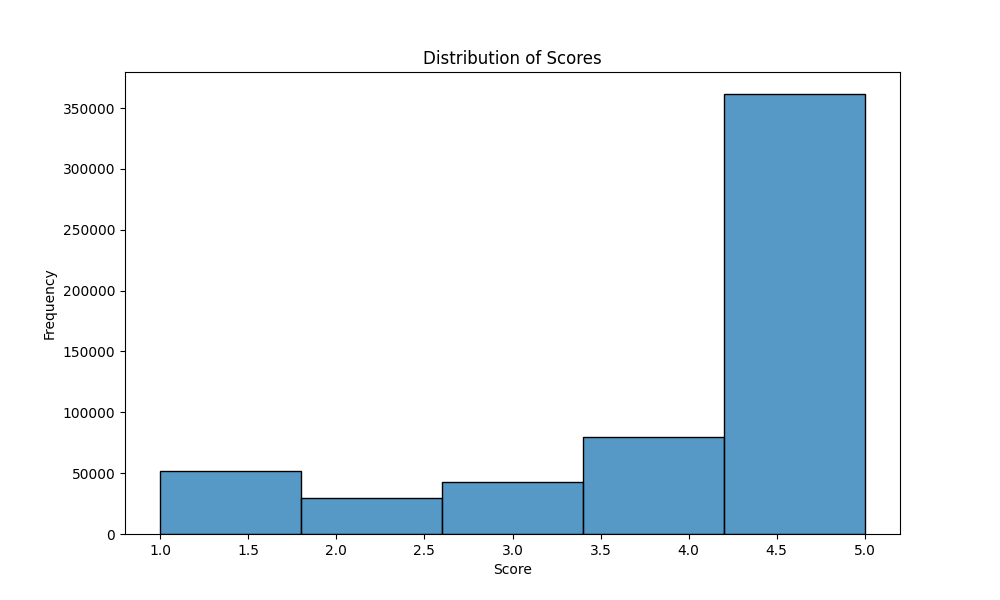

In [25]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.histplot(scores_df, x="Score", bins=5, kde=False)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
#plt.xticks(range(1, 6))  
plt.show()
%matplot plt

We can see that most of the reviews are positive

In [14]:
import re
# Normalize text: convert to lowercase and remove special characters
def normalize_text(text):
    return re.sub(r"[^a-z0-9\s]", "", text.lower())

normalize_udf = udf(normalize_text)

df_clean = df_clean.withColumn("Summary", normalize_udf(col("Summary")))
df_clean = df_clean.withColumn("Text", normalize_udf(col("Text")))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Creating a new column "HelpfulnessRatio" 

In [26]:
# Calculate helpfulness ratio
df_clean = df_clean.withColumn(
    "HelpfulnessRatio", 
    (col("HelpfulnessNumerator") / col("HelpfulnessDenominator")).cast(DoubleType())
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
# Replace infinite values in helpfulness ratio with null
df_clean = df_clean.replace(float("inf"), None)

# Drop rows where HelpfulnessRatio is null
df_clean = df_clean.dropna(subset=["HelpfulnessRatio"])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Distribution of Helpfulness ratio

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

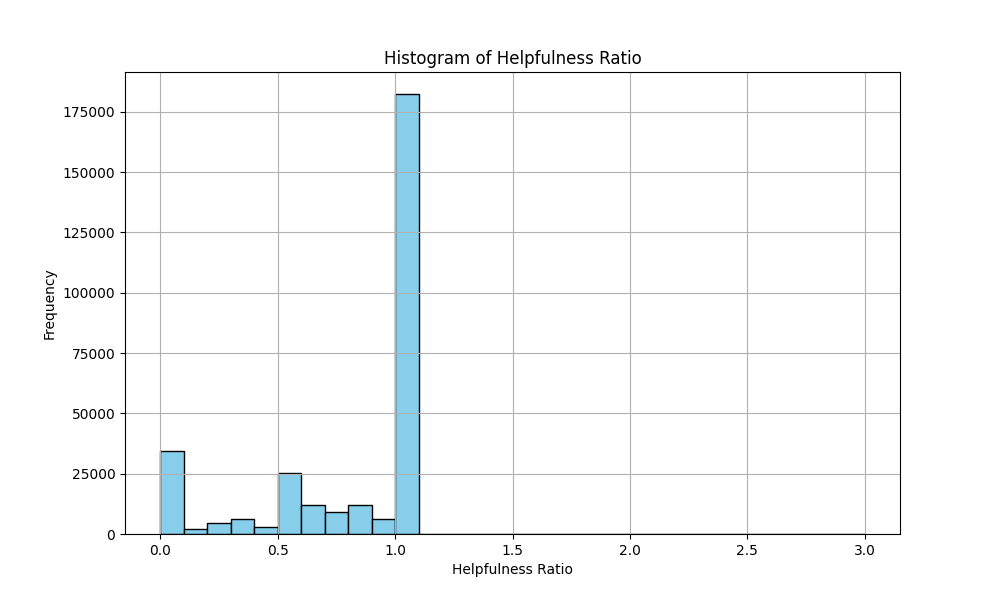

In [33]:
helpfulness_ratio = df_clean.select("HelpfulnessRatio").toPandas()

# Plotting the histogram or count plot
plt.figure(figsize=(10, 6))
plt.hist(helpfulness_ratio['HelpfulnessRatio'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Helpfulness Ratio')
plt.xlabel('Helpfulness Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
%matplot plt

In [28]:
from pyspark.sql.functions import length
# Add length of review text as a feature
df_clean = df_clean.withColumn("TextLength", length(col("Text")).cast(IntegerType()))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
# Show schema of the cleaned dataset
df_clean.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- Id: integer (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: integer (nullable = true)
 |-- HelpfulnessDenominator: integer (nullable = true)
 |-- Score: double (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)
 |-- HelpfulnessRatio: double (nullable = true)
 |-- TextLength: integer (nullable = true)

### Storing transformed data in S3

In [52]:
# Reduce the number of partitions to 1
df_transformed_coalesced = df_clean.coalesce(1)

# Path to save transformed data
transformed_data_path = "s3://lgangumo2/transformed/"

# Write the transformed data to S3 in CSV format
df_transformed_coalesced.write.csv(transformed_data_path, mode='overwrite', header=False)

print("Transformed data successfully written to S3 as a single CSV file.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Transformed data successfully written to S3 as a single CSV file.

### Creating table in Athena

In [ ]:
DATABASE_NAME = "default"
TABLE_NAME = "amazon_review_data"
AWS_REGION = 'us-east-1'

athena = boto3.client('athena', 
    aws_access_key_id='*****************',
    aws_secret_access_key='***************',
    aws_session_token='****************',
    region_name = AWS_REGION)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [73]:
# SQL query to create external table in Athena
create_table_query = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {DATABASE_NAME}.{TABLE_NAME} (
    Id STRING,
    ProductId STRING,
    UserId STRING,
    ProfileName STRING,
    HelpfulnessNumerator INT,
    HelpfulnessDenominator INT,
    Score INT,
    Time INT,
    Summary STRING,
    Text STRING,
    ReviewDate DATE,
    HelpfulnessRatio DOUBLE,
    TextLength INT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION 's3://lgangumo2/transformed/'
"""

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [74]:
create_table_query.strip()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

"CREATE EXTERNAL TABLE IF NOT EXISTS default.amazon_review_data (\n    Id STRING,\n    ProductId STRING,\n    UserId STRING,\n    ProfileName STRING,\n    HelpfulnessNumerator INT,\n    HelpfulnessDenominator INT,\n    Score INT,\n    Time INT,\n    Summary STRING,\n    Text STRING,\n    ReviewDate DATE,\n    HelpfulnessRatio DOUBLE,\n    TextLength INT\n)\nROW FORMAT DELIMITED\nFIELDS TERMINATED BY ','\nLOCATION 's3://lgangumo2/transformed/'"

In [75]:
response = athena.start_query_execution(
    QueryString = create_table_query.strip(),
    QueryExecutionContext = {'Database': DATABASE_NAME},
ResultConfiguration={'OutputLocation': f's3://lgangumo2/query_results/'}
)

print("Athena table creation query submitted.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Athena table creation query submitted.

In [70]:
response

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'QueryExecutionId': '5b363b61-9f1e-4f86-95b9-190e6a48f49a', 'ResponseMetadata': {'RequestId': '22aa3295-654c-4f5e-90bc-714796cf45fe', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Fri, 14 Jun 2024 00:55:18 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '59', 'connection': 'keep-alive', 'x-amzn-requestid': '22aa3295-654c-4f5e-90bc-714796cf45fe'}, 'RetryAttempts': 0}}

In [87]:
athena.get_query_execution(
    QueryExecutionId=response['QueryExecutionId']
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'QueryExecution': {'QueryExecutionId': '55dcbb5e-0625-49b4-9344-0ab360239df8', 'Query': 'SELECT * FROM "default"."amazon_review_data" limit 10', 'StatementType': 'DML', 'ResultConfiguration': {'OutputLocation': 's3://lgangumo2/query_results/55dcbb5e-0625-49b4-9344-0ab360239df8.csv'}, 'ResultReuseConfiguration': {'ResultReuseByAgeConfiguration': {'Enabled': False}}, 'QueryExecutionContext': {'Database': 'default'}, 'Status': {'State': 'SUCCEEDED', 'SubmissionDateTime': datetime.datetime(2024, 6, 14, 1, 8, 30, 164000, tzinfo=tzlocal()), 'CompletionDateTime': datetime.datetime(2024, 6, 14, 1, 8, 31, 146000, tzinfo=tzlocal())}, 'Statistics': {'EngineExecutionTimeInMillis': 744, 'DataScannedInBytes': 1937525, 'TotalExecutionTimeInMillis': 982, 'QueryQueueTimeInMillis': 140, 'ServicePreProcessingTimeInMillis': 75, 'QueryPlanningTimeInMillis': 74, 'ServiceProcessingTimeInMillis': 23, 'ResultReuseInformation': {'ReusedPreviousResult': False}}, 'WorkGroup': 'primary', 'EngineVersion': {'Select

The Status is 'SUCCEEDED'. Hence, the data is sucessfully loaded to athena

In [77]:
select_query = 'SELECT * FROM "default"."amazon_review_data" limit 10;'

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [79]:
response = athena.start_query_execution(
    QueryString = select_query.strip(),
    QueryExecutionContext = {'Database': DATABASE_NAME},
ResultConfiguration={'OutputLocation': f's3://lgangumo2/query_results/'}
)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [82]:
result_response = athena.get_query_results(QueryExecutionId=response['QueryExecutionId'])
for row in result_response['ResultSet']['Rows']:
    print(row['Data'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[{'VarCharValue': 'id'}, {'VarCharValue': 'productid'}, {'VarCharValue': 'userid'}, {'VarCharValue': 'profilename'}, {'VarCharValue': 'helpfulnessnumerator'}, {'VarCharValue': 'helpfulnessdenominator'}, {'VarCharValue': 'score'}, {'VarCharValue': 'time'}, {'VarCharValue': 'summary'}, {'VarCharValue': 'text'}, {'VarCharValue': 'reviewdate'}, {'VarCharValue': 'helpfulnessratio'}, {'VarCharValue': 'textlength'}]
[{'VarCharValue': '464903'}, {'VarCharValue': 'B000LKVIVE'}, {'VarCharValue': 'A1LEW4AOCFJLDO'}, {'VarCharValue': 'Calvin Clift'}, {'VarCharValue': '0'}, {'VarCharValue': '7'}, {'VarCharValue': '1'}, {'VarCharValue': '1252800000'}, {'VarCharValue': 'Awful'}, {'VarCharValue': '"I like exotic flavors but this is just bad'}, {}, {'VarCharValue': '0.0'}, {'VarCharValue': '105'}]
[{'VarCharValue': '464905'}, {'VarCharValue': 'B000CPYVGM'}, {'VarCharValue': 'A2M6L21T224FF8'}, {'VarCharValue': '"\\"Sandra Wood \\"\\"morda02\\"\\"\\""'}, {'VarCharValue': '7'}, {'VarCharValue': '7'}, {'Var

In [92]:
column_names = [col['VarCharValue'] for col in result_response['ResultSet']['Rows'][0]['Data']]

# Extract data starting from the second row in the result response
data = [row['Data'] for row in result_response['ResultSet']['Rows'][1:]]

# Convert data to a list of lists, extracting each value from the dictionary
data_values = [[item.get('VarCharValue', None) for item in row] for row in data]

# Create Pandas DataFrame
df_athena = pd.DataFrame(data_values, columns=column_names)

# Display the first few rows of the DataFrame
print(df_athena.head())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       id   productid          userid  ... reviewdate helpfulnessratio textlength
0  464903  B000LKVIVE  A1LEW4AOCFJLDO  ...       None              0.0        105
1  464905  B000CPYVGM  A2M6L21T224FF8  ...       None             None          1
2  464906  B000CPYVGM  A2MJ8OL2FYN7CW  ...       None             56.0       None
3  464907  B000CPYVGM  A1P186Q24R5X8H  ...       None             None       None
4  464908  B000CPYVGM  A174KTJLMRQE46  ...       None            131.0       None

[5 rows x 13 columns]

Successufully created athena table and loaded the transformed data into it.

### Preparing data for Machine learning model

In [30]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import re



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
# Tokenization and TF-IDF
tokenizer = Tokenizer(inputCol="Text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
vectorizer = CountVectorizer(inputCol="filtered", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Logistic Regression classifier - Predict Score

We will predicting Score based on other features

In [34]:
# Define classifier
lr = LogisticRegression(labelCol="Score", featuresCol="features")

# Define pipeline
pipeline = Pipeline(stages=[tokenizer, remover, vectorizer, idf, lr])

# Split data
train, test = df_clean.randomSplit([0.8, 0.2], seed=42)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
# Train model
model = pipeline.fit(train)

# Make predictions on train data
train_predictions = model.transform(train)

# Evaluate train accuracy
evaluator_train = MulticlassClassificationEvaluator(labelCol="Score", predictionCol="prediction", metricName="accuracy")
train_accuracy = evaluator_train.evaluate(train_predictions)
print(f"Train Accuracy: {train_accuracy}")

# Make predictions on test data
test_predictions = model.transform(test)

# Evaluate test accuracy
evaluator_test = MulticlassClassificationEvaluator(labelCol="Score", predictionCol="prediction", metricName="accuracy")
test_accuracy = evaluator_test.evaluate(test_predictions)
print(f"Test Accuracy: {test_accuracy}")

# Print other metrics (precision, recall, f1-score)
precision = evaluator_test.evaluate(test_predictions, {evaluator_test.metricName: "weightedPrecision"})
recall = evaluator_test.evaluate(test_predictions, {evaluator_test.metricName: "weightedRecall"})
f1_score = evaluator_test.evaluate(test_predictions, {evaluator_test.metricName: "f1"})
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1_score}")



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Train Accuracy: 0.9962756836690414
Test Accuracy: 0.7100696196145697
Precision: 0.7286889509701862
Recall: 0.7100696196145697
F1-score: 0.7177328472745879

The trained logistic regression model achieved high accuracy on the training data (99.63%), indicating a good fit. However, its performance on unseen test data was lower (71.01%), suggesting some overfitting. Precision, recall, and F1-score metrics also reflect reasonable model performance in classifying Amazon product review scores based on textual content.

#### Saving the model to S3 bucket

In [51]:
model.save("s3a://lgangumo2/amazon_review/lr_model/")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Visualizing the results

In [29]:
import matplotlib.pyplot as plt

# Example data
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
scores = [test_accuracy, precision, recall, f1_score]

# Plotting the scores
plt.figure(figsize=(10, 6))
plt.bar(metrics, scores, color='skyblue')
plt.title('Performance Metrics of Logistic Regression')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Assuming scores are between 0 and 1
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

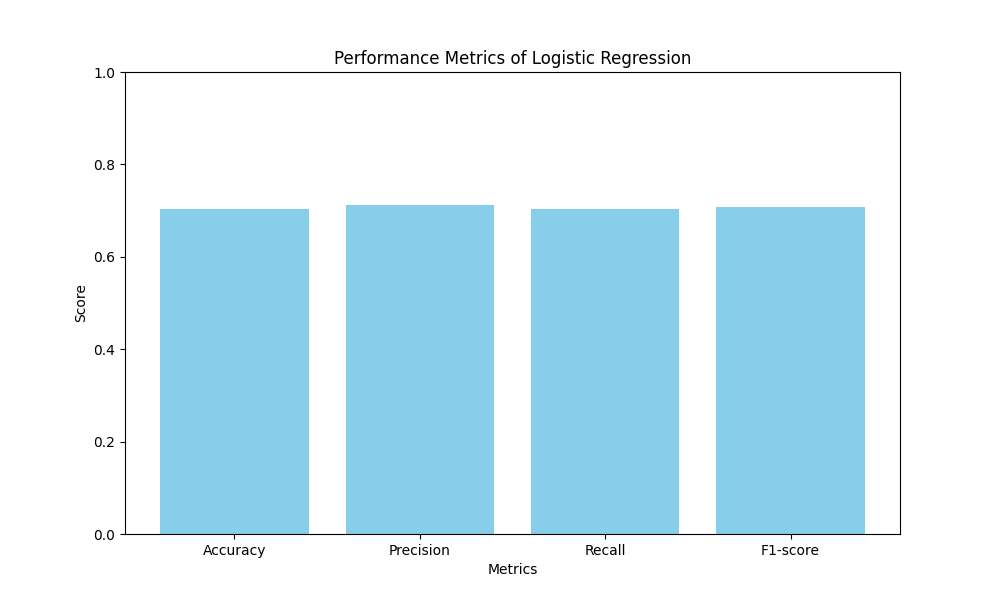

In [30]:
%matplot plt

#### Confusion matrix

In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have the predictions and actual labels
predictions = test_predictions.select('prediction').rdd.map(lambda row: row[0]).collect()
labels = test_predictions.select('Score').rdd.map(lambda row: row[0]).collect()

# Compute confusion matrix
cm = confusion_matrix(labels, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['1', '2', '3', '4', '5'], yticklabels=['1', '2', '3', '4', '5'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

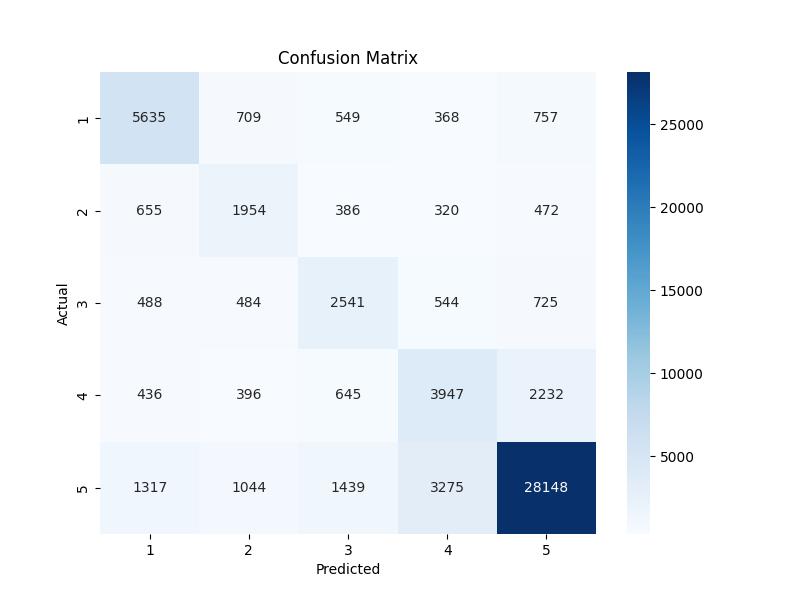

In [43]:
%matplot plt

The confusion matrix displays how well a model predicts Amazon review scores, ranging from 1 to 5. The matrix highlights the model's strength in predicting Class 5 reviews (28,148 correct predictions), indicating a high frequency or better accuracy for this score. However, there are noticeable misclassifications across all classes, with significant errors particularly for predictions involving Class 1 and Class 5, suggesting some bias or difficulty in distinguishing between extreme scores. Overall, the model demonstrates varying degrees of accuracy across different review scores, excelling at Class 5 predictions but struggling with others, which could suggest a skew in the dataset or model towards more positive reviews.

### Visualizations
Visualizations such as bar plots for performance metrics (Accuracy, Precision, Recall, F1-score) and a confusion matrix were created to better understand and interpret the model's results. The confusion matrix highlighted the model's strength in predicting Class 5 reviews but showed challenges in accurately predicting Classes 1 and 2.

### Conclusion

In conclusion, this project successfully processed and transformed a vast Amazon review dataset using PySpark, ensuring data quality and consistency through rigorous preprocessing steps. The cleaned data was efficiently staged in Amazon S3 and structured into an Athena table.

While the logistic regression model demonstrated strong predictive capabilities for certain review scores, it showed limitations in distinguishing between lower ratings (Classes 1 and 2). This suggests potential areas for model improvement, such as incorporating additional features or exploring different algorithms better suited for handling imbalanced classes.

Furthermore, the insights gained from this analysis can assist Amazon in understanding customer sentiment and improving product offerings based on customer feedback.

Overall, the project highlights the application of machine learning techniques using pySPark MLlib in analyzing large-scale review datasets, offering valuable insights into customer preferences and opinions.